In [1]:
################################################################
## Import libraries
import os
import numpy as np
np.set_printoptions(suppress=True)
import math as math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as Ticker
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.signal as sig
import scipy.stats as stats
import scipy.ndimage as spim
from scipy.signal import savgol_filter
import dabest as db2
import datetime
################################################################

In [2]:
import smBaseFunctions3 as sbf
import vBaseFunctions3 as vbf
import smdabest.dabest as db
from my_mpl_defaults import *

In [3]:
from IPython.core.display import display, HTML
import sys
######################################################################
display(HTML("<style>.container { width:75% !important; }</style>"))
!jt -r
sys.executable
######################################################################
plt.rcParams['svg.fonttype'] = 'none'
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
#######################################################################

/tmp/ipykernel_115396/1029096771.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Reset css and font defaults in:
/home/data/.jupyter/custom &
/home/data/.local/share/jupyter/nbextensions


In [4]:
#######################################################################################################################################
def plot_pulse_cross_correl(mouse,
                            cluID,
                            alldesen,
                            allBaseblock,
                            units,
                            group_type,
                            nms=[40,40],
                            binwidth=1,
                            xscale=1,
                            xtwidth=100,
                            ext='.light_pulse',
                            zscore=True,
                            zlims=(-3,8),
                            rawlims=(0,20),
                            y_offset=0.1,
                            size_scale=5,
                            fwd=4,
                            fht=1,
                            fscale = [6,7],
                            fill_and_box=False):
    '''
    
    '''
    ###################################################################################################################
    try: sns.reset_orig()
    except: print()
    desen,baseblock,ipath,bsnm = sbf.get_mouse_info(alldesen,allBaseblock,mouse)
    os.chdir(ipath)
    print(bsnm)
    ###################################################################################################################
    midpoint = int(nms[0] / binwidth)
    baseline = None
    xlab = 'Time (ms)'
    ylab = 'Z-score'
    xmin,xmax = [-nms[0],nms[1]]
    ymin,ymax = [-5,20]
    xtick_width = xtwidth * xscale
    box_lims = [0,5]
    ax_lims = [-nms[0],nms[1]]
    min_dur = None
    ###################################################################################################################
    if zscore:
        ymin,ymax = [zlims[0],zlims[1]]
        ytick_width = int(ymax/2)
        ylab = 'Z-Score'
    else:
        ymin,ymax = [rawlims[0],rawlims[1]]
        ytick_width = ymax
        ylab = 'Counts'

    figsize = [fwd*size_scale,fht*size_scale]
    alpha = 0.2
    lw = 0.5
    pad = 1.5
    set_lims = True
    ###################################################################################################################
    sessions = sbf.get_sessions(desen,sleepbox=True)
    lightC = sbf.pulsecorrelation(baseblock,desen,sessions,cluID,nms=nms,binwidth=binwidth,ext=ext,min_dur=min_dur)
    print(lightC.shape)
    ###################################################################################################################
    fig,ax = sbf.plot_ac(lightC,cluID,units,mouse,nms=nms,binwidth=binwidth,baseline=baseline,
                         figsize=figsize,ac=False,prob=False,zscore=3)
    ###################################################################################################################
    if set_lims:
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)
    ###################################################################################################################
    ax.xaxis.set_major_locator(Ticker.MultipleLocator(xtick_width))
    ax.yaxis.set_major_locator(Ticker.MultipleLocator(ytick_width))
    ###################################################################################################################
    # Plot horizontal line at 0
    ax.axhline(0,linewidth=lw,color='k')
    # set / get x and y limits
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ymin,ymax = ax.get_ylim()
    ymin_ = ymin + y_offset
    ###################################################################################################################
    allSessFR,gmeanFR = sbf.calc_meanFR_one_mouse(alldesen,allBaseblock,units,mouse,'.col2resofs')
    cell_ID = units[mouse]['des'][cluID]
    FRate = 'FR: {0:.2f} Hz'.format(np.round(gmeanFR[cluID-2],1))
    ext_str = ext[1:]
    ax.set_title(ext_str + '_' + bsnm + ' ' + str(cluID) + '_' + cell_ID + ': ' + FRate, fontsize=fscale[1])

    ax.spines['left'].set_position(('outward', 3))
    ax.spines['bottom'].set_position(('outward', 3))
    ax.spines['left'].set_bounds((ymin,ymax))
    ax.spines['bottom'].set_bounds((xmin, xmax))

    ax = sbf.adjust_plot_pub(ax,xlab,ylab,nms=nms,binwidth=binwidth,xscale=xscale,fscale=fscale,grid=False,pad=pad)

    return fig,ax
#######################################################################################################################################
def pulsecorrelation(baseblock,desen,sessions,cluID,binwidth=1,nms=[40.,40.],ext='.light_pulse',min_dur=None,max_dur=None,samp_rate=20000,single_clu=True):
    '''
    This function takes a baseblock,desen dataframe and a list of sessions
    and a cluID and generates an cross-correlation based on pulsetimes in all sessions given
    binwidth and nmsBefore, nmsAfter are passed as options
    returns a matrix (oMat) which is timebins x 1 x totalspikes
    use plot_ac to visualize
    '''
    # Create output matrix
    tbins  = int(2*(nms[0]/binwidth))
    oMat = np.array([]).reshape(tbins,1,0)
    print(oMat.shape)
    if single_clu:
        cluID_list = [cluID]
    else:
        cluID_list = cluID
    # Loop through sessions
    for sindx,sess in enumerate(sessions):
        ### Select session
        sessionLabel = sbf.get_descode(desen,sess)
        fname = baseblock + '_' + str(sessionLabel['filebase'].index[0])
        ##############################################################################################
        res,clu = vbf.LoadSpikeTimes(fname,trode=None,MinCluId=2,res2eeg=(20000./20000))
        ipath = os.path.split(baseblock)[0] + '/'
        reftemp = sbf.get_pulsetimes(ipath,desen,sess,ext,tconv=None,debug=False)
        duration = [(y-x) for x,y in zip(reftemp['begin'].values,reftemp['end'].values)]
        #print(duration)
        refTimes = reftemp['begin'].values
        if min_dur is not None:
            refTimes = [x for (x,y) in zip(refTimes,duration) if y > min_dur*samp_rate]
            min_pulses = 1
        if max_dur is not None:
            refTimes = [x for (x,y) in zip(refTimes,duration) if y < max_dur*samp_rate]
        else:
            min_pulses = 1
        #print('Min pulse duration is {0:}. Min no pulses/sess is {1:}'.format(min_dur,min_pulses))
        if len(refTimes) > min_pulses: # Must be more than one Light ON trial in the session
            refEdges = sbf.generate_edges(refTimes,binwidth=binwidth,nmsBefore=nms[0],nmsAfter=nms[1])
            tempMat = sbf.generate_3Difr_matrix(res,clu,cluID_list,refEdges)
            print(tempMat.shape)
            oMat = np.concatenate((oMat,tempMat),axis=-1)
        ##############################################################################################          
    return oMat
#######################################################################################################################################
def plot_event_raster(actmat,
                      nms=(200,200),
                      binwidth=1,
                      fwd=1.8,fht=2.8,
                      col='k',
                      x_maj_loc=200,
                      y_maj_loc=10,
                      yt_fmt='.0f',
                      despine_x=False,
                      despine_y=False,
                      lw=0.5,
                      fscale=(6,7),
                      ylab='Event #'):
    '''
    
    '''
    actmat_ = actmat.T
    spk2d = [np.where(actmat_[cid,:]) for cid in range(actmat_.shape[0])]
    
    np.random.seed(11)
    colors_ =  [col for _ in range(len(spk2d))]
    lengths_ = [.9 for _ in range(len(spk2d))]
    idx_ = np.arange(len(spk2d))
    spk2d = [sbf.flatten(spk2d[i]) for i in idx_]
    ######################################################################################
    fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht)) #,sharex=True)

    ax.eventplot(spk2d,color=colors_,linewidths=lw*1.5,linelengths=lengths_)

    ax.set_xlim(-5,actmat_.shape[1])
    ax.set_ylim(0,actmat_.shape[0]);

    ax.xaxis.set_major_locator(Ticker.MultipleLocator(x_maj_loc))
    ax.yaxis.set_major_locator(Ticker.MultipleLocator(y_maj_loc))

    yticks = ax.get_yticks().tolist()
    yticks = [format(y,yt_fmt) for y in yticks]
    ax.set_yticklabels(yticks, rotation=0, fontsize=fscale[0])

    ax = sbf.adjust_plot_pub(ax,ylab=ylab,nms=nms,binwidth=binwidth,raster=True,fscale=fscale,grid=False)
    if despine_x:
        sns.despine(bottom=True)
        ax.set_xticks([])
    if despine_y:
        sns.despine(bottom=True,left=True)
        ax.set_yticks([])
        
    return fig,ax
#######################################################################################################################################

In [5]:
################################################################
# Get database entries
################################################################
day_list = ['data_sharing']
group_list = ['neuron']

day_type = day_list[0]
group_type = group_list[0]
old_mpath = '/mnt/smchugh/lfpd4/SF/'
update = False
################################################################
database = sbf.get_database_dl(day_type,
                               group_type,
                               old_mpath=old_mpath,
                               update=update)
################################################################

database rootdir is /Dupret_Lab/analysis/smchugh_analysis/databases
/Dupret_Lab//analysis/smchugh_analysis/databases/data_sharing_neuron.db

0 /Dupret_Lab/merged/smchugh_merged/temp/msm16-181018


In [6]:
celltype=['pdg','p3','p1','bdg','b3','b1']

mouseID,allBaseblock,allPar,alldesen,units = sbf.get_all_mouse_db_info(database,SF=True)
indIDs,origIDs = sbf.get_all_cell_inds(database,units,celltype=celltype,pprint=False,thresh1=200,exact=True)

pdg 18

p3 10

p1 26

bdg 3

b3 6

b1 1



In [38]:
mouse = 0
ctype = 'p3'
print(allBaseblock[mouse])
units[mouse][units[mouse]['des'] == ctype]

/Dupret_Lab/merged/smchugh_merged/temp/msm16-181018/msm16-181018


,trode,trode_unit,des
2,1,2,p3
3,1,3,p3
4,1,4,p3
5,1,5,p3
18,4,2,p3
19,4,3,p3
21,4,5,p3
24,5,3,p3
27,5,6,p3
42,8,2,p3


msm16-181018 ['sb0', 'sbf1s1', 'sbf1s2'] p3
ds (400, 250)


/tmp/ipykernel_115396/2904695462.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[indx].set_xticklabels(xticks,fontsize=fs[0])
/tmp/ipykernel_115396/2904695462.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[indx].set_yticklabels(yticks, rotation=0, fontsize=fs[0])


swr (400, 750)


/tmp/ipykernel_115396/2904695462.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[indx].set_xticklabels(xticks,fontsize=fs[0])
/tmp/ipykernel_115396/2904695462.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[indx].set_yticklabels(yticks, rotation=0, fontsize=fs[0])


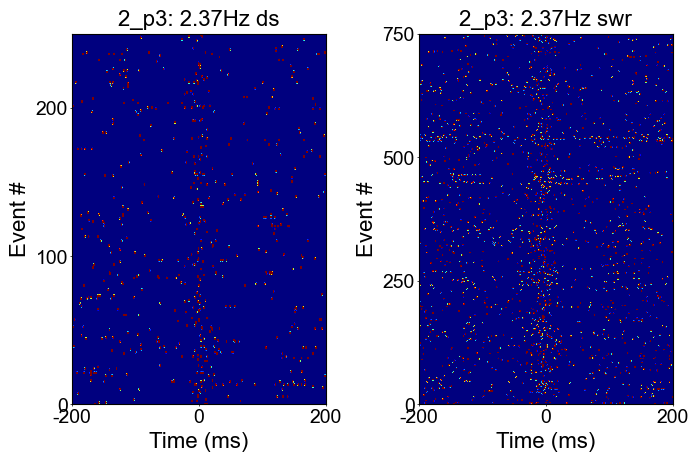

In [43]:
################################################################################################
### get one cell pulse correlation
################################################################################################
mouse = 0
cluID = 2 # 20 # 39
################################################################################################
nms = (200,200)
binwidth = 1
small = False
################################################################################################
event_type_list = ['ds','swr']
ext_list = ['.ds_pulse','.swr_pulse']
vmin_list = [0,0,0,0]
vmax_list =  [.03,.05,.2,.5]
ytick_list = [100,250,100,50]
xtick = 200
xlim = (0,400)
###############################################################################################
min_dur = None
max_dur = None
sleepbox = True
sleeponly = True
###############################################################################################
xlab = 'Time (ms)'
ylab = 'Event #'

lw = 0.5
pad = 1.5
###############################################################################################
if small:
    fwd,fht = 6,4
    fs = [6,7]
else:
    fwd,fht = 18,12
    fs = [14,16]
###############################################################################################
cmap = 'jet'
fig,ax = plt.subplots(1,len(event_type_list),figsize=sbf.cm2inch(fwd,fht))
###############################################################################################
desen,baseblock,ipath,bsnm = sbf.get_mouse_info(alldesen,allBaseblock,mouse)
os.chdir(ipath)
sessions = sbf.get_sessions(desen,sleepbox=sleepbox,sleeponly=sleeponly)
print(bsnm,sessions,units[mouse]['des'][cluID])
allSessFR,gmeanFR = sbf.calc_meanFR_one_mouse(alldesen,allBaseblock,units,mouse,'.col2resofs')
###############################################################################################
max_bin_dict = {'ds':(0,250),
                'swr':(250,1000)}
event_dict = {}
for indx,(event_type,ext) in enumerate(zip(event_type_list,ext_list)):
    event_dict[event_type] = sbf.pulsecorrelation(baseblock,
                                                  desen,
                                                  sessions,
                                                  cluID,
                                                  nms=nms,
                                                  binwidth=binwidth,
                                                  ext=ext,
                                                  min_dur=min_dur)
    lightC = np.squeeze(event_dict[event_type])
    max_bin = max_bin_dict[event_type]
    lightC = lightC[:,max_bin[0]:max_bin[1]]
    print(event_type,lightC.shape)

    stitle = str(cluID) + '_' + units[mouse]['des'][cluID] + ': ' \
             + str(np.round(gmeanFR[cluID-2],2)) + 'Hz' + ' ' + event_type

    pulses = lightC.shape[1]

    im = ax[indx].imshow(lightC.T,
                         aspect='auto',
                         #norm=colors.Normalize(),
                         cmap=cmap,
                         vmin=vmin_list[indx],
                         vmax=vmax_list[indx])

    ax[indx].set_ylim(0,pulses)
    ax[indx].set_title(stitle,fontsize=fs[1])
    ax[indx].set_xlim(xlim)
    ax[indx].xaxis.set_major_locator(Ticker.MultipleLocator(xtick))
    ax[indx].yaxis.set_major_locator(Ticker.MultipleLocator(ytick_list[indx]))
    
    xticks = ax[indx].get_xticks()
    xticks = [format(x-nms[0],'.0f') for x in xticks]
    ax[indx].set_xticklabels(xticks,fontsize=fs[0])
    ax[indx].set_xlabel(xlab,fontsize=fs[1])
    ax[indx].set_ylabel(ylab,fontsize=fs[1])

    yticks = ax[indx].get_yticks()
    yticks = [format(x,'.0f') for x in yticks]
    ax[indx].set_yticklabels(yticks, rotation=0, fontsize=fs[0])
    ax[indx].tick_params(width=lw,length=3*lw,pad=pad)
###############################################################################################
plt.tight_layout()
plt.show()
###############################################################################################

msm16-181018
(400, 1, 322)
ref ID: 2 p3


/ddLab/code/smchugh/py/smBaseFunctions3.py:3279: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(xtlabs,fontsize=SMALL_SIZE)
/ddLab/code/smchugh/py/smBaseFunctions3.py:3280: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(ytlabs,fontsize=SMALL_SIZE)


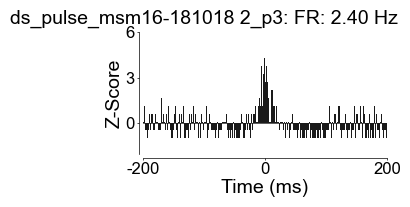

msm16-181018
(400, 1, 2080)
ref ID: 2 p3


/ddLab/code/smchugh/py/smBaseFunctions3.py:3279: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(xtlabs,fontsize=SMALL_SIZE)
/ddLab/code/smchugh/py/smBaseFunctions3.py:3280: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(ytlabs,fontsize=SMALL_SIZE)


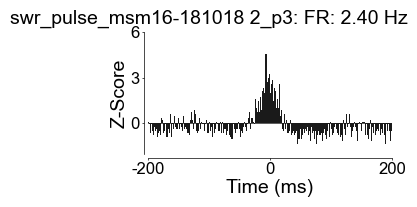

In [44]:
##############################################################################################
fwd,fht = 8,4
fscale = (12,14)
##############################################################################################
for ext in ext_list:
    fig,ax = plot_pulse_cross_correl(mouse,
                                     cluID,
                                     alldesen,
                                     allBaseblock,
                                     units,
                                     group_type,
                                     nms=nms,
                                     binwidth=binwidth,
                                     xscale=1,
                                     xtwidth=200,
                                     ext=ext,
                                     zscore=True,
                                     zlims=(-2.0,6),
                                     rawlims=(0,20),
                                     y_offset=0.1,
                                     size_scale=1,
                                     fwd=fwd,
                                     fht=fht,
                                     fscale=fscale,
                                     fill_and_box=False)
    plt.show()

In [45]:
### Raster

event_type = 'swr'
max_bin_dict = {'ds':(0,250),
                'swr':(250,1000)}

lightC = np.squeeze(event_dict[event_type])
max_bin = max_bin_dict[event_type]
lightC = lightC[:,max_bin[0]:max_bin[1]]
print(event_type,lightC.shape)

actmat = lightC.T
print(actmat.shape)

start_ind = 0
end_ind = start_ind + 400
actmat_ = actmat[:,start_ind:end_ind]
print(actmat_.shape)
spk2d = [np.where(actmat_[cid,:]) for cid in range(actmat_.shape[0])]

np.random.seed(11)
colors_ =  ['k' for _ in range(len(spk2d))]
lengths_ = [.9 for _ in range(len(spk2d))]

idx_ = np.arange(len(spk2d))
spk2d = [sbf.flatten(spk2d[i]) for i in idx_]

swr (400, 750)
(750, 400)
(750, 400)


/tmp/ipykernel_115396/1281501072.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, rotation=0, fontsize=12)


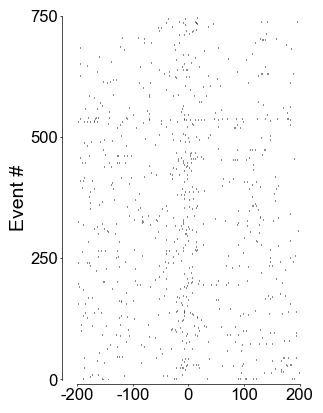

In [46]:
fwd,fht = 8,12
fscale = (12,14)

fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
y_maj_loc = 250
yt_fmat = '.0f'
ylab = 'Event #'

ax.eventplot(spk2d,color=colors_,linewidths=lw*1.5,linelengths=lengths_)
ax.set_ylim(-.4,actmat_.shape[0]);
ax.yaxis.set_major_locator(Ticker.MultipleLocator(y_maj_loc))

yticks = ax.get_yticks().tolist()
yticks = [format(y,yt_fmat) for y in yticks]
ax.set_yticklabels(yticks, rotation=0, fontsize=12)

ylim = ax.get_ylim()
ax = sbf.set_axis_bounds(ax,xlim,ylim)
ax = sbf.adjust_plot_pub(ax,ylab=ylab,nms=nms,binwidth=binwidth,raster=True,fscale=fscale,grid=False)
plt.show()

In [15]:
###############################################################################################
### Generate 3d IFR for one rec day
###############################################################################################
celltype = ['pdg','p3','p1']
sleepbox = True
sleeponly = True
nms = [200,200]
binwidth = 1
###############################################################################################
# oMat is a timebins x 1 x totalspikes output
mouse = 0
print(mouseID[mouse])
bin_range = (0,250)
cluID_list = [17] #sbf.multi_ctype_IDs(celltype,origIDs,mouse)
desen,baseblock,ipath,bsnm = sbf.get_mouse_info(alldesen,allBaseblock,mouse)
os.chdir(ipath)
sessions = sbf.get_sessions(desen,sleepbox=sleepbox,sleeponly=sleeponly)
print(bsnm,sessions)
allSessFR,gmeanFR = sbf.calc_meanFR_one_mouse(alldesen,allBaseblock,units,mouse,'.col2resofs')

nbins = 400
odata = np.array([]).reshape(nbins,0)
###############################################################################################
for indx,cluID in enumerate(cluID_list):
    tempdat = pulsecorrelation(baseblock,
                                desen,
                                sessions,
                                cluID,
                                nms=nms,
                                binwidth=binwidth,
                                ext=ext,
                                min_dur=min_dur,
                                single_clu=True)

    tempdat = np.squeeze(tempdat)
    print()
    print(tempdat.shape)

    odata = np.concatenate((odata,tempdat),axis=-1)
###############################################################################################

msm16-181018
msm16-181018 ['sb0', 'sbf1s1', 'sbf1s2']
(400, 1, 0)
(400, 1, 267)
(400, 1, 865)
(400, 1, 948)

(400, 2080)


In [95]:
##########################################################################################################
sleepbox = True
sleeponly = True

desen,baseblock,ipath,bsnm = sbf.get_mouse_info(alldesen,allBaseblock,mouse)
os.chdir(ipath)
sessions = sbf.get_sessions(desen,sleepbox=sleepbox,sleeponly=sleeponly)
print(bsnm,sessions)

cluID_list = sbf.multi_ctype_IDs(celltype,origIDs,mouse)
ext_list = ['.ds_pulse','.swr_pulse']
nms = (200,200)
binwidth = 1
n_bins = int(np.sum(nms) / binwidth)
max_dur = None

output_dict = {}
for ext_indx,ext in enumerate(ext_list):
    print(ext)
    n_cells = len(cluID_list)
    output_array = np.array([]).reshape(n_bins,n_cells,0)
    print(output_array.shape)
    for sindx,sess in enumerate(sessions):
        ### Select session
        sessionLabel = sbf.get_descode(desen,sess)
        fname = baseblock + '_' + str(sessionLabel['filebase'].index[0])
        
        ##############################################################################################
        res,clu = vbf.LoadSpikeTimes(fname,trode=None,MinCluId=2,res2eeg=(20000./20000))
        ipath = os.path.split(baseblock)[0] + '/'
        reftemp = sbf.get_pulsetimes(ipath,desen,sess,ext,tconv=None,debug=False)
        refTimes = reftemp['begin'].values
        if len(refTimes) > 1:
            refEdges = sbf.generate_edges(refTimes,binwidth=binwidth,nmsBefore=nms[0],nmsAfter=nms[1])
            temp_mat = sbf.generate_3Difr_matrix(res,clu,cluID_list,refEdges)
            print(temp_mat.shape)

            output_array = np.concatenate((output_array,temp_mat),axis=-1)
        else:
            print(sess,'not enough', ext, 'pulses')
    okey = ext[1:].split('_',3)[0]
    output_dict[okey] = output_array

msm16-181018 ['sb0', 'sbf1s1', 'sbf1s2']
.ds_all_no_swr
(400, 54, 0)
(400, 54, 13)
(400, 54, 153)
(400, 54, 95)
.swr_all_no_ds
(400, 54, 0)
(400, 54, 259)
(400, 54, 795)
(400, 54, 887)


ds 28 (400, 54)


/tmp/ipykernel_61480/4268560973.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, rotation=0, fontsize=fscale[0])
/ddLab/code/smchugh/py/smBaseFunctions3.py:3279: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(xtlabs,fontsize=SMALL_SIZE)
/ddLab/code/smchugh/py/smBaseFunctions3.py:3280: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(ytlabs,fontsize=SMALL_SIZE)


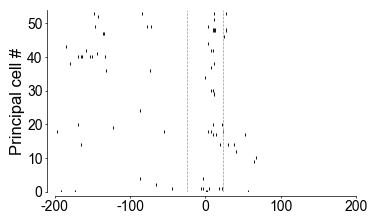

ds 14 (400, 54)


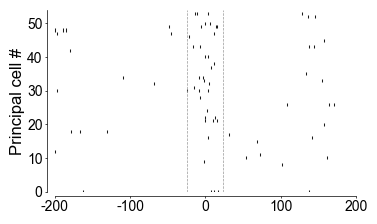

ds 15 (400, 54)


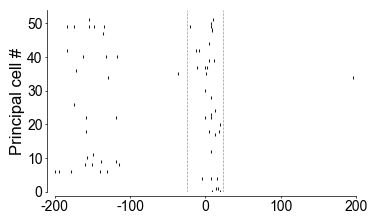

ds 16 (400, 54)


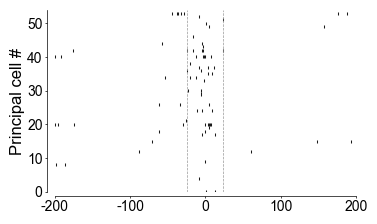

ds 37 (400, 54)


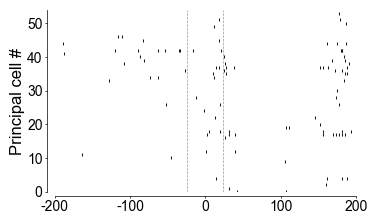

swr 28 (400, 54)


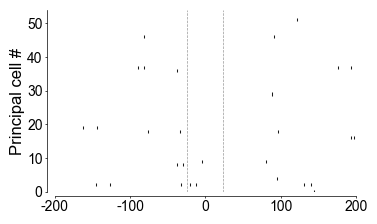

swr 14 (400, 54)


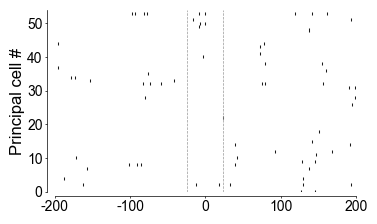

swr 15 (400, 54)


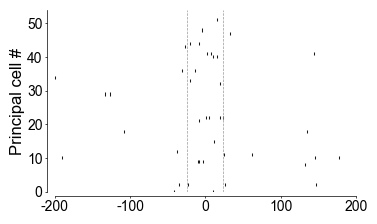

swr 16 (400, 54)


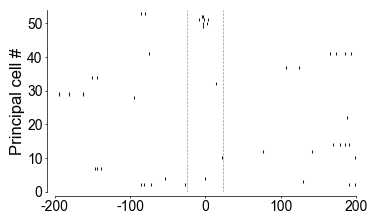

swr 37 (400, 54)


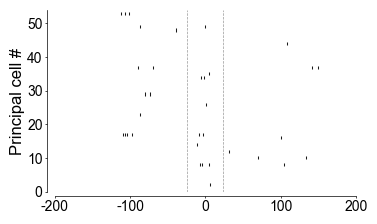

In [96]:
#############################################################################################################
fwd,fht = 10,6
#############################################################################################################
ev_indx_list = [28,14,15,16,37] #[20,22,25]
midpoint = int(np.sum(nms) / 2)
offset = 25
vline_list = [midpoint-offset,midpoint+offset-1]
line_col = gray2
x_maj_loc = 100
y_maj_loc = 10
lw = 0.5
fscale = (10,12)
despine_x = False
despine_y = False
############################################################################################################
for key,val in output_dict.items():
    output_array = output_dict[key]
    despine_y = False
    ylab = 'Principal cell #'
    for fig_indx,ev_indx in enumerate(ev_indx_list):
        actmat = output_array[:,:,ev_indx]
        print(key,ev_indx,actmat.shape)
        fig,ax = plot_event_raster(actmat,
                                   nms=nms,
                                   binwidth=binwidth,
                                   fwd=fwd,
                                   fht=fht,
                                   col='k',
                                   x_maj_loc=x_maj_loc,
                                   y_maj_loc=y_maj_loc,
                                   yt_fmt='.0f',
                                   despine_x=despine_x,
                                   despine_y=despine_y,
                                   lw=lw,
                                   fscale=fscale,
                                   ylab=ylab
                                  )
        ylim = ax.get_ylim()
        ax = sbf.set_axis_bounds(ax,xlim,ylim)
        for vline in vline_list:
            ax.axvline(vline,linewidth=lw,linestyle='--',color=line_col)
        plt.show()
        
        ftitle = '_'.join(('Raster_one_event',
                           day_type,
                           group_type,
                           bsnm,
                           key,
                           str(ev_indx),
                           str(fwd) + 'x' + str(fht))
                         )
        ##########################################################################################

/tmp/ipykernel_61480/4268560973.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, rotation=0, fontsize=fscale[0])


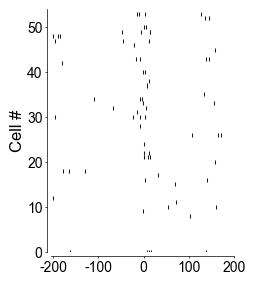

In [97]:
fwd,fht = 6,8

ev_indx = 14
okey = 'ds'
output_array = output_dict[okey]
actmat = output_array[:,:,ev_indx]

fig,ax = plot_event_raster(actmat,
                       nms=nms,
                       binwidth=binwidth,
                       fwd=fwd,
                       fht=fht,
                       col='k',
                       x_maj_loc=100,
                       y_maj_loc=10,
                       yt_fmt='.0f',
                       despine_x=False,
                       despine_y=False,
                       lw=lw,
                       fscale=fscale,
                       ylab='Cell #')

#ylim = ax.get_ylim()
#ax = sbf.set_axis_bounds(ax,xlim,ylim)

plt.show()